## Building Stable Diffusion Variational AutoEncoder from Scratch using PyTorch

# Train VAE Scheme

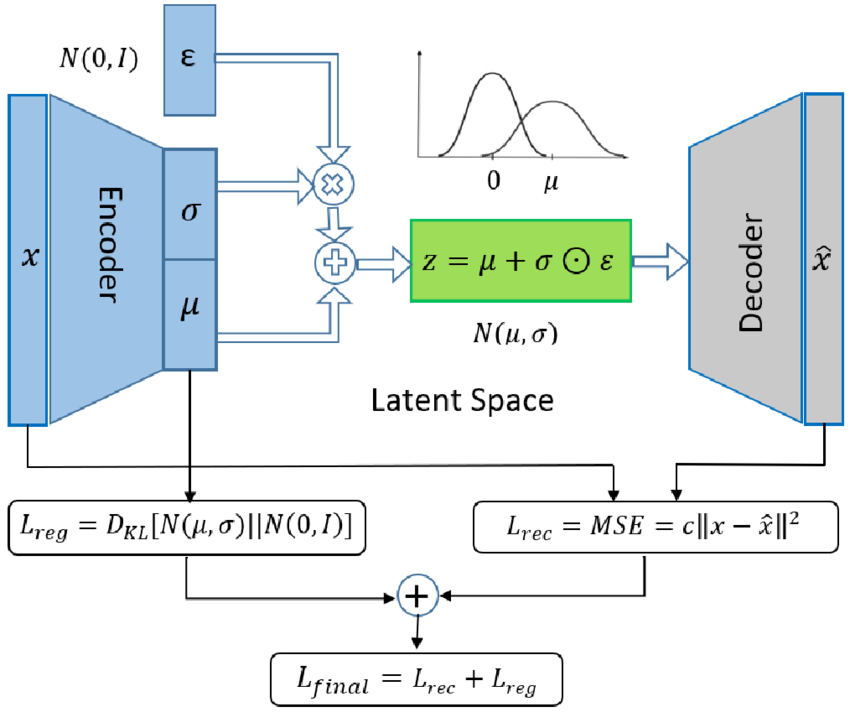

In [ ]:
# import modules
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import shutil
import math
import os

```SelfAttention``` is machanism which achieve attention in a single sequence, means it calculates attention among all the tokens within single sequence.

Attention help us to pay attention with different intensity among all tokens in the sequence. Self-attention is widely used in the encoder part of the Transformer model, where the model needs to understand and encode the entire input sequence’s context.

In [ ]:
# self attention
class SelfAttention(nn.Module):

  def __init__(self, n_head, n_embd, in_proj_bias=True, out_proj_bias=True):

    super().__init__()

    # key, query, value projections
    self.in_proj = nn.Linear(n_embd, 3 * n_embd, bias=in_proj_bias)
    # output projection
    self.out_proj = nn.Linear(n_embd, n_embd, bias=out_proj_bias)

    self.n_head = n_head
    self.n_embd = n_embd

    self.d_head = n_embd // n_head # dimensionality of each head(d_model)

  def forward(self, x, casual_mask=True):
    # (B, T, C) - batch_size, seq_len, d_embd

    batch_size, seq_len, d_embd = x.shape

    interim_shape = (batch_size, seq_len, self.n_head, self.d_head)

    # (B, T, C) -> 3 * (B, T, C)
    q, k, v = self.in_proj(x).chunk(3, dim=1)

    # change the shape of q,k,v to match interim shape
    q = q.view(interim_shape)
    k = k.view(interim_shape)
    v = v.view(interim_shape)

    # swap elements within matrix using traspose
    # (B, T, n_head, n_embd // n_head) -> (B, n_head, T, head_size)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # calculate the attention

    # attention (materializes the large(T, T) matrix for all the queries and keys)
    # in official gpt2 used `torch.baddbmm`- batch matrix-matrix product of matrice (it is a bit more efficient)
    # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float("-inf"))
    # att = F.softmax(att, dim=-1)
    # y = att @ v # (B, n_head, T, T) @ (B, n_head, T, hs) -> (B, n_head, T, hs) weighted sum of the tokens that model found interesting

    # (B, n_head, T, T) @ (B, n_head, T, hs) -> (B, n_head, T, hs) weighted sum of the tokens that model found interesting
    output = F.scaled_dot_product_attention

    # re-assemble all head outputs side by side
    # (B, n_head, T, dim/h) -> (B, T, n_head, dim/h)
    output.transpose(1, 2)

    # change the shape to the shape of out_proj
    output = output.reshape((batch_size, seq_len, d_embd))
    output = self.out_proj(output)

    return output

```AttentionBlock``` uses self-attention using residual techinque with group normalization as all the features we have are pixels values and attention tries to find what are good features to pay attention in all features

In [ ]:
class AttentionBlock(nn.Module):

  def __init__(self, channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, channels)
    self.attention = SelfAttention(1, channels)

  def forward(self, x):
    # x:(batch_size, channels, h, w)
    residual = x.clone()

    x = self.groupnorm(x)

    N, C, H, W = x.shape

    x = x.view((N, C, H * W))
    x = x.transpose(-1, -2) # (N, C, H * W) -> (N, H*W, C)

    # perform self-attetion without mask
    x = self.attention(x)
    x = x.transpose(-1, -2)
    x = x.view((N, C, H, W))

    x += residual

    return x



we implement ```ResidualBlock``` part in Encoder and Decoder parts of our Diffusion Model



In [ ]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # (batch_size, in_channels, H, W)
    identity = x.clone() # residual path

    x = self.groupnorm1(x)
    x = F.selu(x)
    x = self.conv1(x)
    x = self.groupnorm2(x)
    x = self.conv2(x)
    x = x + self.residual_layer(identity)

    return x

```Encoder``` this part help us to encode the images in latents with lower dimensions, it consist of convolutional layers to extract features, residual block to maintain and allow to build deeper networks.

In ```forward``` method we extract mean and standard deviation from output of the encoder and build final latent "z" with them


In [ ]:
class Encoder(nn.Sequential):
  r"""
  The `Encoder` layer of a variational autoencoder that encodes its input into a latent representation.
  """


  def __init__(self):
    super().__init__(
        nn.Conv2d(3, 128, kernel_size=3, padding=1),            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
        ResidualBlock(128, 128),                                # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
        nn.Conv2d(128, 128, kernel_size=3,stride=2, padding=0), # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
        ResidualBlock(128, 256),                                # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
        ResidualBlock(256, 256),                                # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
        nn.Conv2d(256, 256, kernel_size=3,stride=2, padding=0), # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
        ResidualBlock(256, 512),                                # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
        ResidualBlock(512, 512),                                # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
        nn.Conv2d(512, 512, kernel_size=3,stride=2, padding=0), # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
        ResidualBlock(512, 512),                                # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
        ResidualBlock(512, 512),
        ResidualBlock(512, 512),
        AttentionBlock(512),
        ResidualBlock(512, 512),
        nn.GroupNorm(32, 512),
        nn.SiLU(),
        nn.Conv2d(512, 8, kernel_size=3, padding=1),            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
        nn.Conv2d(8, 8, kernel_size=1, padding=0)               # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
    )

  def forward(self, x):
    # (batch_size, channels, h, w)

    for module in self:
      if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
        x = F.pad(x, (0, 1, 0, 1)) # (left, right, top, bottom)
      x = module(x)

    # chunking to 2 tensors shape of (batch_size, 4, h / 8, w / 8)
    mean, log_variance = torch.chunk(x, 2, dim=1)

    # clamp log variance between -30 to 20
    log_variance = torch.clamp(log_variance, -30, 20)

    # Reparameterization trick (Process of generating a latent)
    std = torch.exp(0.5 * log_variance)
    eps = torch.randn_like(std)
    x = mean + eps * std

    # scaling latent representation constant
    x *= 0.18215

    return x


```Decoder``` decode the latents to the original output, it also consist of attnetion block, residual block and Upsample layer which add features to add more dimensions to the image to turn back to original image.



In [ ]:
class Decoder(nn.Sequential):
  r"""
  The `Decoder` layer of a variational autoencoder that decodes its latent representation into an output sample.
  """

  def __init__(self):
    super().__init__(
        nn.Conv2d(4, 512, kernel_size=3, padding=1),            # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)
        ResidualBlock(512, 512),                                # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
        AttentionBlock(512),                                    # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
        ResidualBlock(512, 512),                                # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
        ResidualBlock(512, 512),                                # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
        ResidualBlock(512, 512),                                # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
        nn.Upsample(scale_factor=2),                            # (batch_size, 512, 32, 32) -> (batch_size, 512, 64, 64)
        nn.Conv2d(512, 512, kernel_size=3, padding=1),          # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
        ResidualBlock(512, 512),                                # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
        ResidualBlock(512, 512),                                # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
        ResidualBlock(512, 512),                                # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
        nn.Upsample(scale_factor=2),                            # (batch_size, 512, 64, 64) -> (batch_size, 512, 128, 128)
        nn.Conv2d(512, 512, kernel_size=3, padding=1),          # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
        ResidualBlock(512, 256),                                # (batch_size, 512, 128, 128) -> (batch_size, 256, 128, 128)
        ResidualBlock(256, 256),                                # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
        ResidualBlock(256, 256),                                # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
        nn.Upsample(scale_factor=2),                            # (batch_size, 256, 128, 128) -> (batch_size, 256, 256, 256)
        nn.Conv2d(512, 512, kernel_size=3, padding=1),          # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
        ResidualBlock(256, 128),                                # (batch_size, 256, 256, 256) -> (batch_size, 128, 256, 256)
        ResidualBlock(128, 128),                                # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
        ResidualBlock(128, 128),                                # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
        nn.GroupNorm(32, 128),
        nn.SiLU(),
        nn.Conv2d(128, 3, kernel_size=3, padding=1),            # (batch_size, 128, 256, 256) -> (batch_size, 3, 256, 256)
    )

    def forward(self, x):

      # x: (batch_size, 4, h/8, w/8)
      # remove the scaling adding by the encoder
      x /= 0.18215

      for module in self:
        x = module(x)

      # (batch_size, 3, h, w)
      return x

# Download and Preprocess Data

In [ ]:
!gdown 1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV

Downloading...
From (original): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV
From (redirected): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV&confirm=t&uuid=c742863c-737d-4e10-9e24-5a3f0b2b0fa2
To: /content/all-dogs.zip
100% 775M/775M [00:13<00:00, 56.5MB/s]


In [ ]:
!unzip all-dogs.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n0209233

In [ ]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
  image_files = [f for f in os.listdir(source_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

  train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(test_dir, exist_ok=True)

  for file in train_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

  for file in test_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

  print(f"Dataset split complete. {len(train_files)} training examples, {len(test_files)} test examples")

source_dir = "./all-dogs"
train_dir = "./data/train/dogs"
test_dir = "./data/test/dogs"

split_dataset(source_dir=source_dir, train_dir=train_dir, test_dir=test_dir)

Dataset split complete. 16463 training examples, 4116 test examples


# Implementing Variational Autoencoder(VAE)

In [ ]:
# Model

class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded, encoded

# Train the VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
# from model import Encoder, Decoder

# Device configuration
if torch.cuda.is_available:
  device = torch.device("cuda")

# Hyperparameters
num_epochs = 100
lr = 6e-4
beta = 0.00025 # KL divergence weight

# Data loading
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
batch_size = 4
dataset = torchvision.datasets.ImageFolder(root="./data/train", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Additional hyperparameters
accum_steps = 1
effective_batch_size = batch_size * accum_steps

train_losses = []

# training loop
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for i, (images, _) in enumerate(dataloader):
    images = images.to(device)

    # Forward pass
    reconstructed, encoded = model(images)

    # Compute loss(reconstruction loss)
    recon_loss = nn.MSELoss()(reconstructed, images)

    # Extract mean and log_variance from encoder
    mean, log_variance = torch.chunk(encoded, 2, dim=1)

    # formula of KL Divergence
    kl_div = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    loss = recon_loss + beta * kl_div

    # Normalize the loss to account for accumulation
    loss = loss / accum_steps

    # backward pass
    loss.backward()

    # training loop that performs gradient accumulation every {accum_steps} batches
    if (i + 1) % accum_steps == 0:
      optimizer.step()
      optimizer.zero_grad()

    train_loss += loss.item() * accum_steps

    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
          f'Loss: {loss.item()*accum_steps:.4f}, Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}')


    with torch.no_grad():
      # Take the first image from the batch
      sample_image = images[0].unsqueeze(0)
      sample_reconstructed = model(sample_image)[0]

      sample_image = (sample_image * 0.5) + 0.5
      sample_reconstructed = (sample_reconstructed * 0.5) + 0.5

      torchvision.utils.save_image(sample_reconstructed, "sample_reconstructed.png")

  train_losses.append(train_loss / len(dataloader))

  # Save the model checkpoint
  torch.save(model.state_dict(), f"vae_model_epoch_{epoch+1}.pth")

print(f"Training finished")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import matplotlib.pyplot as plt

# plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss over Time')
plt.legend()
plt.show()

## Using your VAE in Stable Diffusion Pipeline

In [ ]:
class CustomVAE(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    z = self.encode(x)
    x_reconstructed = self.decode(z)

    return x_reconstructed

  def load_pretrained_weights(self, weight_path):
    self.load_state_dict(torch.load(weight_path))

## Diffuser Compatible VAE

In [ ]:
from diffusers import AutoencoderKL

class DiffuserCompatibleVAE(AutoencoderKL):

  def __init__(self, vae):
    super().__init__()
    self.vae = vae

  def encode(self, x):
    mean, log_var = self.vae.encoder(x)
    print("mean")
    return mean, log_var

  def decode(self, z, **kwargs):
    print("Input shape:", z.shape)
    out = self.vae.decoder(z).unsqueeze(0)
    print(out.shape)
    return out

## Install Stable Diffusion model from HuggingFace

In [ ]:
# for install Stable Diffusion model from HuggingFace

# pip install --upgrade diffusers transformers scipy


In [ ]:
from huggingface_hub import snapshot_download

snapshot_download("CompVis/stable-diffusion-v1-4", local_dir="./model")

In [ ]:
AutoencoderKL.from_pretrained("./model/vae")

## Train our custom VAE

In [1]:
import torch

weights = torch.load("/content/vae_model_epoch_100.pth", map_location="cpu")

new_weights = {}
for k, v in weights.items():
  # First remove underscores from keys like: "groupnorm_1"
  new_key = k.replace("_", "")

  # Then add underscores in specific patterns to match "CustomVAE"
  new_key = new_key.replace("residuallayer", "residual_layer") \
                   .replace("inproj", "in_proj") \
                   .replace("outproj", "out_proj")

  new_weights[new_key] = v

vae = CustomVAE()
vae.load_state_dict(new_weights)

device = ["cuda" if torch.cuda.is_available() else "cpu"]
vae = vae.to(device)

SyntaxError: incomplete input (<ipython-input-1-1bfd6315e5f5>, line 11)

## Architecture of VAE

In [ ]:
vae

## Stable Diffusion Pipeline

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "CompVis/stable-diffusion-v1-4"
device = ["cuda" if torch.cuda.is_available() else "cpu"]

vae = CustomVAE()
compatible_vae = DiffuserCompatibleVAE(vae=vae)
pipe = StableDiffusionPipeline.from_pretrained(model_id, vae=compatible_vae)
pipe = pipeline.to(device)

## Sample Image Generation

In [ ]:
prompt = "a photo of a dog"
image = pipe(prompt, num_inference_steps=50).images[0]

In [ ]:
image